https://keras.io/examples/nlp/lstm_seq2seq/

In [73]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [74]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "fra.txt"

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
        
    # fill remaining chars with blank
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0


Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 94
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [95]:
target_texts[-10:]

['\tIl fallait que nous arrêtions.\n',
 '\tIl nous fallait arrêter.\n',
 '\tIl nous fallait cesser.\n',
 '\tIl fallait que nous cessions.\n',
 '\tIl fallut que nous arrêtions.\n',
 '\tIl fallut que nous cessions.\n',
 '\tIl nous fallut cesser.\n',
 '\tIl nous fallut arrêter.\n',
 '\tNous avons un accord.\n',
 '\tNous avons conclu un accord.\n']

In [82]:
target_texts[0]

'\tVa !\n'

In [22]:
test_input = keras.Input(shape=(15,71))
test_lstm = keras.layers.LSTM(5, return_state=True)(test_input)
test_model = keras.Model(test_input, test_lstm)

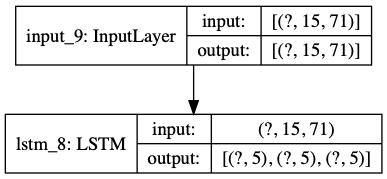

In [23]:
keras.utils.plot_model(test_model, show_shapes=True)

In [24]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

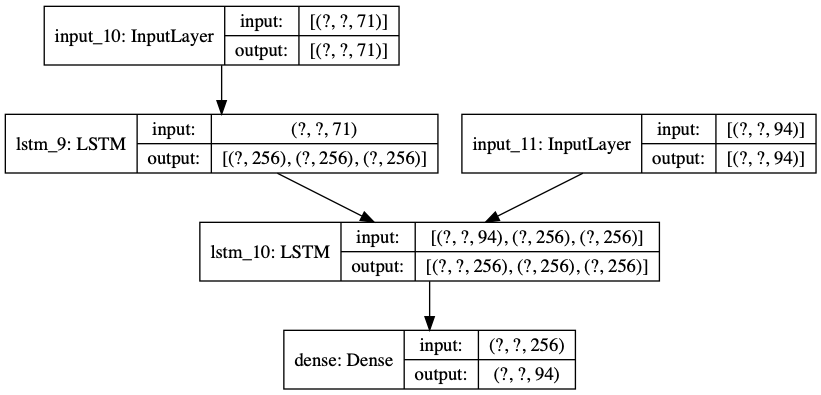

In [25]:
keras.utils.plot_model(model, show_shapes=True)

In [96]:
decoder_target_data[0, 1, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [6]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

Epoch 1/100
125/125 [==============================] - 14s 110ms/step - loss: 1.1867 - accuracy: 0.7261 - val_loss: 1.0718 - val_accuracy: 0.7075
Epoch 2/100
125/125 [==============================] - 13s 106ms/step - loss: 0.8622 - accuracy: 0.7680 - val_loss: 0.8836 - val_accuracy: 0.7496
Epoch 3/100
125/125 [==============================] - 15s 121ms/step - loss: 0.6942 - accuracy: 0.8057 - val_loss: 0.7075 - val_accuracy: 0.7953
Epoch 4/100
125/125 [==============================] - 16s 125ms/step - loss: 0.5949 - accuracy: 0.8274 - val_loss: 0.6504 - val_accuracy: 0.8098
Epoch 5/100
125/125 [==============================] - 28s 225ms/step - loss: 0.5433 - accuracy: 0.8411 - val_loss: 0.6132 - val_accuracy: 0.8181
Epoch 6/100
125/125 [==============================] - 16s 126ms/step - loss: 0.5054 - accuracy: 0.8519 - val_loss: 0.5862 - val_accuracy: 0.8272
Epoch 7/100
125/125 [==============================] - 17s 138ms/step - loss: 0.4764 - accuracy: 0.8593 - val_loss: 0.5663 -

125/125 [==============================] - 14s 115ms/step - loss: 0.0986 - accuracy: 0.9689 - val_loss: 0.5814 - val_accuracy: 0.8725
Epoch 57/100
125/125 [==============================] - 14s 114ms/step - loss: 0.0960 - accuracy: 0.9696 - val_loss: 0.5927 - val_accuracy: 0.8710
Epoch 58/100
125/125 [==============================] - 14s 115ms/step - loss: 0.0940 - accuracy: 0.9703 - val_loss: 0.5957 - val_accuracy: 0.8726
Epoch 59/100
125/125 [==============================] - 14s 115ms/step - loss: 0.0921 - accuracy: 0.9707 - val_loss: 0.5952 - val_accuracy: 0.8727
Epoch 60/100
125/125 [==============================] - 15s 120ms/step - loss: 0.0899 - accuracy: 0.9716 - val_loss: 0.6017 - val_accuracy: 0.8722
Epoch 61/100
125/125 [==============================] - 14s 113ms/step - loss: 0.0882 - accuracy: 0.9719 - val_loss: 0.6021 - val_accuracy: 0.8717
Epoch 62/100
125/125 [==============================] - 19s 150ms/step - loss: 0.0860 - accuracy: 0.9724 - val_loss: 0.6145 - val_a

In [7]:
model.save("s2s")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: s2s/assets


In [98]:
model.layers

**Inference:**

In [26]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

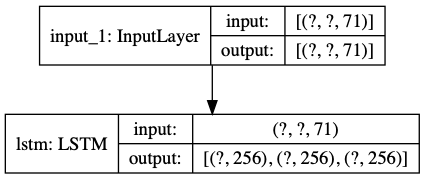

In [50]:
keras.utils.plot_model(encoder_model, show_shapes=True)

In [97]:
encoder_model.layers

In [30]:
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)

decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

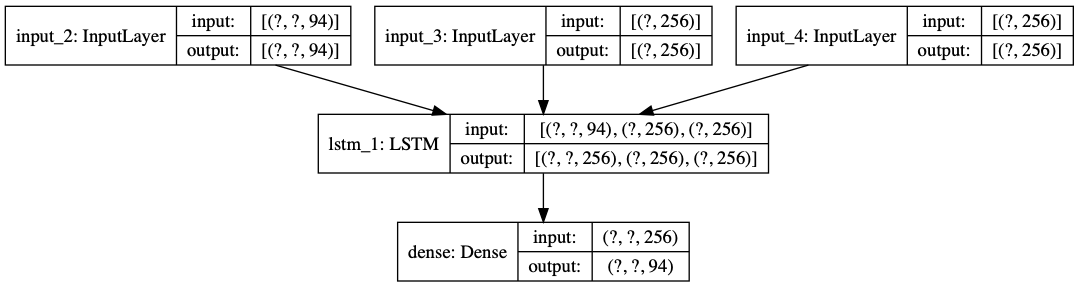

In [31]:
keras.utils.plot_model(decoder_model, show_shapes=True)

In [11]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [12]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [55]:
encoded = encoder_model.predict(encoder_input_data[0:1])
encoded[1].shape

(1, 256)

In [56]:
target_seq = np.zeros((1, 1, num_decoder_tokens))
target_seq[0, 0, target_token_index["\t"]] = 1.0
target_seq.shape

(1, 1, 94)

In [57]:
decoder_input = [target_seq] + encoded
[ i.shape for i in decoder_input ]

[(1, 1, 94), (1, 256), (1, 256)]

In [58]:
output_tokens, h, c = decoder_model.predict(decoder_input)

In [61]:
output_tokens.shape

(1, 1, 94)

In [71]:
np.argmax(output_tokens[0, 0, :])

43

In [13]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)


-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Hello!
Decoded sentence: Salut !

-
Input sentence: Hello